#### CSCE 670 :: Information Storage and Retrieval :: Texas A&M University :: Spring 2018


# Homework 3:  Embeddings + Recommenders

### 100 points [5% of your final grade]

### Due: Monday, April 9 by 11:59pm

*Goals of this homework:* There are two main learning objectives: (i) implement and evaluate a pre-cursor to modern word2vec embeddings; and (ii) implement, evaluate, and improve upon traditional collaborative filtering recommenders.

*Submission Instructions:* To submit your homework, rename this notebook as UIN_hw#.ipynb. For example, this homework submission would be: YourUIN_hw3.ipynb. Submit this notebook via ecampus. Your notebook should be completely self-contained, with the results visible in the notebook. 

*Late submission policy:* For this homework, you may use up to three of your late days, meaning that no submissions will be accepted after Thursday, April 12 at 11:59pm.

# Part 1: Word Embeddings (50 points)
For this first part, we're going to implement a word embedding approach that is a bit simpler than word2vec. The key idea is to look at co-occurrences between center words and context words (somewhat like in word2vec) but without any pesky learning of model parameters.

If you're interested in a deeper treatment of comparing count vs. learned embeddings, take a look at: [Don’t count, predict! A systematic comparison of
context-counting vs. context-predicting semantic vectors](
http://www.aclweb.org/anthology/P14-1023)

## Load the Brown Corpus

The dataset for this part is the (in)famous [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) that is a collection of text samples from a wide range of sources, with over one million unique words. Good for us, you can find the Brown corpus in nltk. *Make sure you have already installed nltk with something like: conda install nltk*

In [1]:
import nltk
nltk.download('brown')


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\pragy\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Once you have it locally, you can load the dataset into your notebook. You can access the words using brown.words():

In [2]:
from nltk.corpus import brown
brown.words()

[u'The', u'Fulton', u'County', u'Grand', u'Jury', ...]

## 1.1 Dataset Pre-processing
OK, now we need to do some basic pre-processing. For this part you should:

* Remove stopwords and punctuation.
* Make everything lowercase.

Then, count how often each word occurs. We will define the 5,000 most  frequent words as your vocabulary (V). We will define the 1,000 most frequent words as our context (C). Include a print statement below to show the top-20 words after pre-processing.

In [3]:
# Your Code Here...
'''
Removing the stopwords using the stopwords from 3 libraries -- 
1. nltk
2. sklearn
3. spacy

- Removing blank spaces, numbers and '$'
'''

from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en import STOP_WORDS as STOPWORDS
import re
import operator

stop = set(stopwords.words('english') + list(string.punctuation) + ['the'] + ["''"] + ["``"] + list('1234567890'))
stop.add(ENGLISH_STOP_WORDS)
stop.union(STOPWORDS)

data = []

#[i for i in word_tokenize(sent.lower()) if i not in stop]
dict_word = {}
digits = ['1','2','3','4','5','6','7','8','9','0', '$', '-', '/', '.']
digits_set = set(digits)
data = []

for word in brown.words():
    data.append(word)
    if word.lower() not in stop:
        if word[0] not in digits_set:  #removing digits
            if word.lower() in dict_word:
                dict_word[word.lower()] += 1
            else:
                dict_word[word.lower()] = 1
            
i = 0
dict_word = sorted(dict_word.items(), key = lambda x:x[1], reverse=True)
print(dict_word[:20])




[(u'one', 3292), (u'would', 2714), (u'said', 1961), (u'new', 1635), (u'could', 1601), (u'time', 1598), (u'two', 1412), (u'may', 1402), (u'first', 1361), (u'like', 1292), (u'man', 1207), (u'even', 1170), (u'made', 1125), (u'also', 1069), (u'many', 1030), (u'must', 1013), (u'af', 996), (u'back', 966), (u'years', 950), (u'much', 937)]


In [28]:
import unicodedata
from collections import Counter


context = set()
vocab = set()
context_dict = {}
vocab_dict = {}
i = 0
for w in dict_word[:1000]:
        first =  w[0]
        second = unicodedata.normalize('NFKD', first).encode('ascii','ignore')
        context_dict[str(second)] = i
        i += 1
        context.add(w[0])
vocab_list = []
i = 0
for w in dict_word[:5000]:
    first = w[0]
    second = unicodedata.normalize('NFKD', first).encode('ascii','ignore')
    vocab_dict[str(second)] = i
    i += 1
    vocab_list.append(w[0])
    vocab.add(w[0])
print(vocab_list)

[u'one', u'would', u'said', u'new', u'could', u'time', u'two', u'may', u'first', u'like', u'man', u'even', u'made', u'also', u'many', u'must', u'af', u'back', u'years', u'much', u'way', u'well', u'people', u'mr.', u'little', u'state', u'good', u'make', u'world', u'still', u'see', u'men', u'work', u'long', u'get', u'life', u'never', u'day', u'another', u'know', u'last', u'us', u'might', u'great', u'old', u'year', u'come', u'since', u'go', u'came', u'right', u'used', u'take', u'three', u'states', u'use', u'house', u'without', u'place', u'american', u'around', u'however', u'home', u'small', u'found', u'mrs.', u'thought', u'went', u'say', u'part', u'general', u'high', u'upon', u'school', u'every', u'got', u'united', u'left', u'number', u'course', u'war', u'always', u'away', u'something', u'fact', u'water', u'though', u'public', u'put', u'less', u'think', u'almost', u'hand', u'enough', u'took', u'far', u'head', u'yet', u'government', u'system', u'set', u'better', u'told', u'night', u'nothin

## 1.2  Making the co-occurance matrix!

Making the co-occurance matrix here, with the vocabulary as rows and context as columns, the dicitonaries made int he previous cell come to the rescue to link the specific column or row number with the exact word.

In [6]:
# Your Code Here...
cooc_matrix = []

for word in vocab:
    temp = []
    for cont in context:
        temp.append(0)
    cooc_matrix.append(temp)
#print(len(cooc_matrix))

#initializes a 5000x1000 matrix

# need to map each vocab word with a number and each context word with a number
# given in the above cell


i = 0
# data = data[:500]
matrix_sum = 0

for word in data:
    ind = i
    if word.lower() in vocab:
        matrix_v_ind = vocab_dict[word.lower()]
        window = data[ind-2:ind+3]
        #print(window)
        for j in window:
            if j.lower() in context:
                #print("yo!")
                matrix_sum += 1
                matrix_c_ind = context_dict[j.lower()]
                cooc_matrix[matrix_v_ind][matrix_c_ind] += 1
    i += 1
#print(cooc_matrix[:20][:20]) 
print("Number of times the condition met is:")
print(matrix_sum)
print("")


Number of times the condition met is:
510507



In [7]:
matrix_sum = 0

for row in range(len(cooc_matrix)):
    for col in range(len(cooc_matrix[0])):
        matrix_sum += cooc_matrix[row][col]
print(matrix_sum)

510507


## 1.3 Probability Distribution

Using the co-occurrence matrix, we can compute the probability distribution Pr(c|w) of context word c around w as well as the overall probability distribution of each context word c with Pr(c).  

In [8]:
# Your Code Here...
# As far as I understood the question, Pr(c|w) = element/row_sum, and Pr(c) = Column_sum/matrix_sum

pr_matrix = []

for row in range(len(cooc_matrix)):
    temp = []
    for col in range(len(cooc_matrix[0])):
        temp.append(0)
    pr_matrix.append(temp)

row_sum = 0

for row in range(len(cooc_matrix)):
    row_sum = sum(cooc_matrix[row])
    #print(row_sum)
    for col in range(len(cooc_matrix[0])):
        if row_sum != 0:
            pr_matrix[row][col] = (cooc_matrix[row][col])/float(row_sum)
        else:
            pr_matrix[row][col] = 0

In [11]:
col_sum = [0]*len(cooc_matrix[0])

for row in range(len(cooc_matrix)):
    for col in range(len(cooc_matrix[0])):
        col_sum[col] += cooc_matrix[row][col]
print(col_sum[:20])
#print(len(col_sum))

pr_c = [0]*1000
# total = 0
for i in range(len(col_sum)):
    pr_c[i] = (col_sum[i]/float(matrix_sum))
print(pr_c[:20])

[7420, 6469, 3288, 4065, 3779, 3160, 3512, 3353, 3048, 2981, 2552, 2480, 2440, 2473, 2444, 2462, 2138, 2125, 2311, 2045]
[0.014534570534782089, 0.012671716548450854, 0.0064406560536878045, 0.0079626724021414, 0.0074024450203425225, 0.006189924917777817, 0.006879435541530283, 0.006567980458642095, 0.0059705351738565775, 0.005839293094903694, 0.0049989520222053765, 0.004857915758256008, 0.004779562278284137, 0.0048442038992609305, 0.004787397626281324, 0.004822656692268666, 0.004187993504496511, 0.004162528623505652, 0.0045268723053748525, 0.00400582166356191]


In [9]:
print(len(pr_matrix))
print(len(pr_matrix[0]))

print(vocab_list[0])

5000
1000
one


## 1.4 Embedding Representation

Now you can represent each vocabulary word as a |C| dimensional vector using this equation:

Vector(w)= max(0, log (Pr(c|w)/Pr(c)))

This is a traditional approach called *pointwise mutual information* that pre-dates word2vec by some time. 

In [12]:
# Your Code Here...
import math

#print(len(pr_matrix[0]))
vector_matrix = []

for row in range(len(pr_matrix)):
    temp = []
    for col in range(len(pr_matrix[0])):
        if pr_c[col] != 0.0:
            if pr_matrix[row][col]/pr_c[col] != 0.0 or pr_matrix[row][col]/pr_c[col] != 0 :
                temp.append(max(0, math.log(pr_matrix[row][col]/(pr_c[col]))))
            else:
                temp.append(0)
        else:
            temp.append(0)
               
    vector_matrix.append(temp)
print(vector_matrix[:20][:20])
print(len(vector_matrix))

[[3.6290498900242163, 0, 0, 0, 0, 0, 0.032935871619046916, 0, 0, 0, 0.25460571234545765, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.43304664993141173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.1418995776391732, 1.0117510779407803, 0, 0, 0, 0.31538953570525907, 0, 0, 0.3248028465071806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.3312112369900353, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8080079876114519, 0, 0.37379794970796826, 0, 0, 0, 0, 0, 0, 0, 0.5330308670649426, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.4525232193333608, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09838596984800163, 0, 0, 0.1729968336391764, 0.11818859714418138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.2944021318358427, 0, 0, 0, 1.9997651640932792, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.10494337039416068, 0, 0, 0, 0, 0, 0, 0, 0.2893724095276802, 0, 0, 0, 0, 0, 0, 1.126046522543827, 0, 0, 0, 0, 0, 0, 0, 0, 0, 


5000


## 1.5 Analysis

So now we have some embeddings for each word. But are they meaningful? For this part, you should:

- First, cluster the vocabulary into 100 clusters using k-means. Look over the words in each cluster, can you see any relation beween words? Discuss your observations.

- Second, for the top-20 most frequent words, find the nearest neighbors using cosine distance (1- cosine similarity). Do the findings make sense? Discuss.

In [18]:
# Your Code Here...
from sklearn.cluster import KMeans

vector_matrix1 = vector_matrix[:2000][:200]
# X = [[1, 2, 3], [1, 4, 4], [1, 0, 6],
#               [4, 2, 1], [4, 4, 6], [4, 0, 4]]
kmeans = KMeans(n_clusters=100, random_state=0).fit(vector_matrix)
# kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

print kmeans.labels_
 

[17 59  4 ... 17 17 17]


In [19]:
print(len(vector_matrix))
print(len(vector_matrix[0]))

5000
1000


In [31]:
for i, label in enumerate(kmeans.labels_, start=0):
    if label == 0:
        print vocab_list[i]
for i, label in enumerate(kmeans.labels_, start=0):
    if label == 1:
        print vocab_list[i]

bone
rolling


In [33]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(4, 0, metric='cosine')
neighbors.fit(vector_matrix)
#print(neigh)
distances, indices = neighbors.kneighbors(vector_matrix)
#print(indices[:20])

counter = 0
for i in indices:
    temp = []
    for j in i:
        temp.append(vocab_list[j])
    if counter < 20:
        print(temp)
        counter += 1


[u'one', u'another', u'thing', u'every']
[u'would', u'could', u"can't", u'might']
[u'said', u'skyros', u'casey', u'smiled']
[u'new', u'york', u'city', u'central']
[u'could', u'would', u"can't", u"i'll"]
[u'time', u'period', u'long', u'short']
[u'two', u'three', u'four', u'several']
[u'may', u'might', u'motive', u'would']
[u'first', u'second', u'next', u'fourth']
[u'like', u'look', u'looked', u"i'd"]
[u'man', u'woman', u'young', u'old']
[u'even', u'though', u'greater', u'perhaps']
[u'made', u'make', u'attempt', u'making']
[u'also', u'rico', u'religion', u'used']
[u'many', u'two', u'several', u'different']
[u'must', u'able', u'therefore', u'follow']
[u'af', u'vertex', u'c', u'vector']
[u'back', u'home', u'kate', u'toward']
[u'years', u'ago', u'hundred', u'decades']
[u'much', u'less', u'greater', u'nothing']


Findings
-------------
The findings certainly make sense. Even with a small size of neighbours, 4, the words are related to each other. 

For example, 
- 'new', 'york' and 'city' are together, probably representing the NEW YORK CITY.
- 'two', 'three', 'four, 'several' are together -- more than one!
- 'first', 'second', 'fourth' are together -- representing the numbers.
- 'made', 'make', 'making' are together.
- 'much', 'less', 'greater', 'nothing' are together -- which absolutely makes sense!

Hence, the neighbors are in a sense correct and do represent the related words.

# Part 2. Collaborative Filtering (50 points)

In this second part, you will implement collaborative filtering on the Netflix prize dataset -- don’t freak out, the provided sample dataset has only ~2000 items and ~28,000 users.

As background, read the paper [Empirical Analysis of Predictive Algorithms for Collaborative Filtering](https://arxiv.org/pdf/1301.7363.pdf) up to Section 2.1. Of course you can read further if you are interested, and you can also refer to the course slides for collaborative filtering.

## RUNNING ON TEST SET OF 10,000 USERS TO VERIFY IF THE SCRIPT IS WORKING OR NOT
----------------------------------------
This primarily helps in debug before running over the entire dataset, which takes up a lot of time.

In [2]:
user_dict = {}
counter = 1
no_movies = set()
no_users = 0
movies_list = []

with open("test.txt",'r') as file:
    line = file.read()
    #line gives each line of the file
    split_line = line.split('\n')
    for l in split_line:
        elements = l.split(',')
        counter += 1
        no_movies.add(int(float(elements[0])))
        
        #elements[1] = userid, 
        #elements[0] = movies_id, 
        #elements[2] = rating by elements[1] on elements[0]
        
        
        temp = {'avg': 0}
        if int(float(elements[1])) in user_dict:
            #print("out")
            user_dict[int(float(elements[1]))][int(float(elements[0]))] = int(float(elements[2])) 
            user_dict[int(float(elements[1]))]['avg'] += int(float(elements[2]))
            
        else:
            temp[int(float(elements[0]))] = int(float(elements[2]))
            #print("in", i)
            #i += 1
            temp['avg'] += int(float(elements[2]))
            user_dict[int(float(elements[1]))] = temp
            no_users += 1
#             if no_users >= 5000:
#                 break
            
            #user_dict[] += int(float(elements[2]))

#calculating the average for each user
for k,v in user_dict.items():
    
    number_of_ratings = len(v.keys())-1  #no of movies rated by the user
    all_movies = set()
    true_avg = v['avg']/float(number_of_ratings)
    user_dict[k]['avg'] = true_avg
    for k_inner,v_inner in v.items():
        if k_inner != 'avg':
            all_movies.add(k_inner)
    user_dict[k]['all'] = all_movies

    
            
            
print("No of ratings are: ", counter) 
print("No of unique users are:", len(user_dict.keys()))
print("No of unique movies are:", len(no_movies))
movies_list = list(no_movies)
print("Unique movies:", movies_list)
#print(user_dict)

'''
user_dict = 

{user1: {item1: rating, item2: rating}, 
 user2: {item1: rating, item2: rating}}

{1765381: {8: 4}, 2105990: {8: 4}, 2637831: {8: 4}, 2551764: {8: 3},
1646405: {8: 5}, 1339724: {8: 3}, 1863499: {8: 5, 9: 4}}
'''    

('No of ratings are: ', 10001)
('No of unique users are:', 9378)
('No of unique movies are:', 2)
('Unique movies:', [8, 28])


'\nuser_dict = \n\n{user1: {item1: rating, item2: rating}, \n user2: {item1: rating, item2: rating}}\n\n{1765381: {8: 4}, 2105990: {8: 4}, 2637831: {8: 4}, 2551764: {8: 3},\n1646405: {8: 5}, 1339724: {8: 3}, 1863499: {8: 5, 9: 4}}\n'

In [3]:
# TEST BLOCK -- Load test data


test_user_dict = {}
counter = 1
test_no_movies = set()
test_no_users = 0
test_movies_list = []
test_unique_movie_list = []
test_user_list = []
test_movies_ratings = []

with open("test_sample.txt",'r') as file:
    line = file.read()
    #line gives each line of the file
    split_line = line.split('\n')
    for l in split_line:
        elements = l.split(',')
        counter += 1
        test_no_movies.add(int(float(elements[0])))
        test_user_list.append(int(float(elements[1])))
        test_movies_list.append(int(float(elements[0])))
        test_movies_ratings.append(int(float(elements[2])))
        
        #elements[1] = userid, 
        #elements[0] = movies_id, 
        #elements[2] = rating by elements[1] on elements[0]
        
        
        temp = {'avg': 0}
        if int(float(elements[1])) in test_user_dict:
            #print("out")
            test_user_dict[int(float(elements[1]))][int(float(elements[0]))] = int(float(elements[2])) 
            test_user_dict[int(float(elements[1]))]['avg'] += int(float(elements[2]))
            
        else:
            temp[int(float(elements[0]))] = int(float(elements[2]))
            #print("in", i)
            #i += 1
            temp['avg'] += int(float(elements[2]))
            test_user_dict[int(float(elements[1]))] = temp
            
            #user_dict[] += int(float(elements[2]))

#calculating the average for each user
for k,v in test_user_dict.items():
    
    test_number_of_ratings = len(v.keys())-1  #no of movies rated by the user
    all_movies = set()
    true_avg = v['avg']/float(number_of_ratings)
    test_user_dict[k]['avg'] = true_avg
#     print(type(v))
    
    for k_inner,v_inner in v.items():
        if k_inner != 'avg':
            all_movies.add(k_inner)
    test_user_dict[k]['all'] = all_movies
        

    
            
            
print("No of ratings are: ", counter) 
print("No of unique users are:", len(test_user_dict.keys()))
print("No of unique movies are:", len(test_no_movies))
test_unique_movies_list = list(test_no_movies)
#print("Unique movies:", test_unique_movies_list)
#print(test_user_dict)

'''
test_user_dict = 

{user1: {item1: rating, item2: rating}, 
 user2: {item1: rating, item2: rating}}

{1765381: {8: 4}, 2105990: {8: 4}, 2637831: {8: 4}, 2551764: {8: 3},
1646405: {8: 5}, 1339724: {8: 3}, 1863499: {8: 5, 9: 4}}
'''    

('No of ratings are: ', 10001)
('No of unique users are:', 8275)
('No of unique movies are:', 173)


'\ntest_user_dict = \n\n{user1: {item1: rating, item2: rating}, \n user2: {item1: rating, item2: rating}}\n\n{1765381: {8: 4}, 2105990: {8: 4}, 2637831: {8: 4}, 2551764: {8: 3},\n1646405: {8: 5}, 1339724: {8: 3}, 1863499: {8: 5, 9: 4}}\n'

In [23]:
# CALCULATE PEARSON COEFFICIENT!
# the index of the dictionary will be the sum of both the users, this will serve dual perpose -
# easy to access while calculating the final values
# will avoid repetition
import math


pearson = {}
from scipy import stats
import numpy as np

user_list = user_dict.keys()

k = 0
length_list = len(user_list)

for i in range(0, length_list):
    user1 = user_list[i]
    for j in range(i+1, length_list):
        user2 = user_list[j] 
        common_movies = list(user_dict[user1]['all'] & user_dict[user2]['all'])

        
        #common_movies has the common_movies
        #need to make to lists with the ratings for the input to the pearson!
        rating_user1 = []
        rating_user2 = []
        for movie in common_movies:
            rating_user1.append(user_dict[user1][movie])
            rating_user2.append(user_dict[user2][movie])
        ratingnp_user1 = np.array(rating_user1)
        ratingnp_user2 = np.array(rating_user2)
        pear = stats.pearsonr(ratingnp_user1, ratingnp_user2)
#         print(rating_user1, rating_user2, pear )
        #print(type(pear[0]))
        if not np.isnan(pear[0]):
            pearson[user1+user2] = pear[0]       
print(pearson)

{2621440: 1.0, 2097152: -1.0, 2621442: 1.0, 3932164: 1.0, 2883592: -1.0, 2621450: -1.0, 3670029: 1.0, 4718606: -1.0, 1835024: -1.0, 3102040: -1.0, 2621458: 1.0, 2883603: -1.0, 2359316: -1.0, 1048601: -1.0, 524318: 1.0, 786467: 1.0, 786469: 1.0, 3145766: -1.0, 4456488: 1.0, 2883626: -1.0, 2359343: 1.0, 2359348: -1.0, 4718645: -1.0, 2621495: 1.0, 3145784: -1.0, 3407929: -1.0, 4194363: -1.0, 917514: 1.0, 1835070: -1.0, 524351: -1.0, 3145796: 1.0, 786504: -1.0, 4194377: 1.0, 1048651: 1.0, 2097228: 1.0, 1835087: -1.0, 3145810: 1.0, 2359380: -1.0, 2883670: -1.0, 2621527: 1.0, 2883673: 1.0, 3407963: 1.0, 3932258: 1.0, 2097254: 1.0, 786537: 1.0, 4456555: 1.0, 2359404: 1.0, 1572882: 1.0, 2479051: 1.0, 2621551: 1.0, 3145843: 1.0, 1310836: 1.0, 4456569: 1.0, 2097274: -1.0, 3670140: -1.0, 2621566: 1.0, 2883713: -1.0, 1572995: 1.0, 4194436: 1.0, 3932294: -1.0, 1835143: -1.0, 3145866: 1.0, 3408015: 1.0, 2883728: -1.0, 1573012: -1.0, 3145877: 1.0, 2359449: 1.0, 2883739: -1.0, 3145884: -1.0, 3670176: 

## Explaination
-------------------------------
The logic here does not hold since many user pairs can have the same sum and hence, lead to an incorrect result.
This has been rectified in the main script, where the pearson dict holds the keys as 'user1 , user2' format.
And hence, removes the chance of the above mentioned error.

## 2.1 Load Netflix Data

The dataset is subset of movie ratings data from the Netflix Prize Challenge. Download the dataset from Piazza. It contains a train set, test set, movie file, and README file. The last two files are original ones from the Netflix Prize, however; in this homework you will deal with train and test files which both are subsets of the Netflix training data. Each of train and test files has lines having this format: MovieID,UserID,Rating.

Your job is to predict a rating in the test set using those provided in the training set.

## FULLDATASET - LOAD THE TRAIN SET
------------------------------------------------

In [32]:
#RUN -- LOAD THE DATA SET

#NEW CODE-- FULL DATA_SET
from collections import defaultdict

full_user_dict = {}
counter = 1
full_no_movies = set()
full_no_users = 0
full_movies_list = []
full_average = 0

with open("TrainingRatings.txt",'r') as file:
    line = file.read()
    #line gives each line of the file
    split_line = line.split('\n')
    for l in split_line:
        elements = l.split(',')
        counter += 1
        #print(type(elements[0]))
        #print(elements[0])
        full_no_movies.add(elements[0])
        full_average += float(elements[2])
        
        #elements[1] = userid, 
        #elements[0] = movies_id, 
        #elements[2] = rating by elements[1] on elements[0]
        
        
        temp = {'avg': 0}
        if elements[1] in full_user_dict:
            #print("out")
            full_user_dict[elements[1]][elements[0]] = float(elements[2]) 
            full_user_dict[elements[1]]['avg'] += float(elements[2])
            
        else:
            temp[elements[0]] = float(elements[2])
            #print("in", i)
            #i += 1
            temp['avg'] += float(elements[2])
            full_user_dict[elements[1]] = temp
            full_no_users += 1

        
full_movies_dict = defaultdict(list)
#calculating the average for each user
for k,v in full_user_dict.items():
    
    full_number_of_ratings = len(v.keys())-1  #no of movies rated by the user
    full_all_movies = set()
    true_avg = v['avg']/float(full_number_of_ratings)
    full_user_dict[k]['avg'] = true_avg
    for k_inner,v_inner in v.items():
        if k_inner != 'avg':
            full_all_movies.add(k_inner)
            full_movies_dict[k_inner].append(k)
            
    full_user_dict[k]['all'] = full_all_movies
          
print("No of ratings are: ", counter) 
print("No of unique users are:", len(full_user_dict.keys()))
print("No of unique movies are:", len(full_no_movies))
full_movies_list = list(full_no_movies)
global_average = full_average/float(counter)
print("Global Average: ", full_average/float(counter))
print(global_average)

'''
user_dict = 

{user1: {item1: rating, item2: rating}, 
 user2: {item1: rating, item2: rating}}

{1765381: {8: 4}, 2105990: {8: 4}, 2637831: {8: 4}, 2551764: {8: 3},
1646405: {8: 5}, 1339724: {8: 3}, 1863499: {8: 5, 9: 4}}
'''    

('No of ratings are: ', 3255353)
('No of unique users are:', 28978)
('No of unique movies are:', 1821)
('Global Average: ', 3.4811865257008994)
3.4811865257


'\nuser_dict = \n\n{user1: {item1: rating, item2: rating}, \n user2: {item1: rating, item2: rating}}\n\n{1765381: {8: 4}, 2105990: {8: 4}, 2637831: {8: 4}, 2551764: {8: 3},\n1646405: {8: 5}, 1339724: {8: 3}, 1863499: {8: 5, 9: 4}}\n'

In [29]:
movie_bias = {}

for movie, users in full_movies_dict.items():
    total = 0
    counter = 0
    for user in users:
        total += full_user_dict[user][movie]
        counter += 1
    movie_bias[movie] = float(total)/counter
#print(movie_bias)

## LOAD THE TEST SET
-----------------------------------

In [58]:
#RUNNNN -- LOAD THE TEST SET

# TEST BLOCK -- Load test data


full_test_user_dict = {}
counter = 1
full_test_no_movies = set()
full_test_no_users = 0
full_test_movies_list = []
full_test_unique_movie_list = []
full_test_user_list = []
full_test_movies_ratings = []

with open("TestingRatings.txt",'r') as file:
    line = file.read()
    #line gives each line of the file
    split_line = line.split('\n')
    for l in split_line:
        elements = l.split(',')
        counter += 1
        full_test_no_movies.add(elements[0])
        full_test_user_list.append(elements[1])
        full_test_movies_list.append(elements[0])
        full_test_movies_ratings.append(float(elements[2]))
        
        #elements[1] = userid, 
        #elements[0] = movies_id, 
        #elements[2] = rating by elements[1] on elements[0]
        
        
        temp = {'avg': 0}
        if elements[1] in full_test_user_dict:
            #print("out")
            full_test_user_dict[elements[1]][elements[0]] = float(elements[2]) 
            full_test_user_dict[elements[1]]['avg'] += float(elements[2])
            
        else:
            temp[elements[0]] = float(elements[2])
            #print("in", i)
            #i += 1
            temp['avg'] += float(elements[2])
            full_test_user_dict[elements[1]] = temp
            
            #user_dict[] += int(float(elements[2]))

#calculating the average for each user
for k,v in full_test_user_dict.items():
    
    full_test_number_of_ratings = len(v.keys())-1  #no of movies rated by the user
    full_all_movies = set()
    true_avg = v['avg']/float(full_number_of_ratings)
    v['avg'] = true_avg
#     print(type(v))
    
    for k_inner,v_inner in v.items():
        if k_inner != 'avg':
            full_all_movies.add(k_inner)
    v['all'] = full_all_movies
        

    
            
            
print("No of ratings are: ", counter) 
print("No of unique users are:", len(full_test_user_dict.keys()))
print("No of unique movies are:", len(full_test_no_movies))
full_test_unique_movies_list = list(full_test_no_movies)
#print("Unique movies:", test_unique_movies_list)
#print(test_user_dict)
print(len(full_test_movies_ratings))

'''
test_user_dict = 

{user1: {item1: rating, item2: rating}, 
 user2: {item1: rating, item2: rating}}

{1765381: {8: 4}, 2105990: {8: 4}, 2637831: {8: 4}, 2551764: {8: 3},
1646405: {8: 5}, 1339724: {8: 3}, 1863499: {8: 5, 9: 4}}
'''    

('No of ratings are: ', 100479)
('No of unique users are:', 27555)
('No of unique movies are:', 1701)
100478


'\ntest_user_dict = \n\n{user1: {item1: rating, item2: rating}, \n user2: {item1: rating, item2: rating}}\n\n{1765381: {8: 4}, 2105990: {8: 4}, 2637831: {8: 4}, 2551764: {8: 3},\n1646405: {8: 5}, 1339724: {8: 3}, 1863499: {8: 5, 9: 4}}\n'

In [20]:
print(len(full_test_movies_ratings))

100478


## 2.2 Implement CF

In this part, you will implement the basic collaborative filtering algorithm described in Section 2.1 of the paper -- that is, focus only on Equations 1 and 2 (where Equation 2 is just the Pearson correlation). You should consider the first 5,000 users with their associated items in the test set. 

Note that you should test the algorithm for a small set of users e.g., 10 users first and then run for 5,000 users. It may take long to run but you won't have memory issues. 

Set k to 0.1. 

In [47]:
# Your Code Here...
#test_movies_list = list of test movies
#test_user_list = list of test user, just predict their scores and store in a list!

'''
full_predicitions : will store the predicition values
'full_test_user_list': just reads from the test set and has the user_id as read from the test set.
'full_test_movies list': same as above, has the movie:
'''

from scipy import stats
import numpy as np
import math

full_pearson = {}
full_predictions = []
full_len_test_user_list = len(full_test_user_list)
users_set = set()

for i in range(0, full_len_test_user_list):
    user1 = full_test_user_list[i]
    #print(user1)
    users_set.add(user1)
    if len(users_set) == 5000:
        break
    
    #get the current movie
    movie = full_test_movies_list[i]
   # print("movie", movie)
    
    
    #movie is there, user is there, just need to predict the rating now!
    #term holds the sigma values, after k*sigma in the formula
    term = 0
    
    #get all the users that have rated the current movie
    common_users = full_movies_dict[movie]
    #print("common_usres", common_users)
    
    
    for user2 in common_users:
        #need to find the pearson and the total and then add, first find pearson
        if user1 + ',' + user2 not in full_pearson and user2 + ',' + user1 not in full_pearson:
            #finding the common movies rated by both the users
            #full_user_dict = {user1 : {'all' : [movie1, movie2, movie4], 'avg': 4.5, 'movie1': rating1, 'movie2': rating2.... }}
            full_common_movies = list(full_user_dict[user1]['all'] & full_user_dict[user2]['all'])
            #common_movies has the common_movies
            #need to make to lists with the ratings for the input to the pearson!
            full_rating_user1 = []
            full_rating_user2 = []
            for movie in full_common_movies:
                full_rating_user1.append(full_user_dict[user1][movie])
                full_rating_user2.append(full_user_dict[user2][movie])
            full_ratingnp_user1 = np.array(full_rating_user1)
            full_ratingnp_user2 = np.array(full_rating_user2)
            full_pear = stats.pearsonr(full_ratingnp_user1, full_ratingnp_user2)
            if not np.isnan(full_pear[0]):
                full_pearson[user1 + ',' + user2] = full_pear[0]
        if user1 + ',' + user2 in full_pearson and movie in full_user_dict[user2]:
            w = full_pearson[user1 + ',' + user2]
            v_bar = full_user_dict[user2]['avg']
            v_i_j = full_user_dict[user2][movie]
            
            term += w*(v_i_j - v_bar)
    if movie in full_user_dict[user2]:       
        total = full_user_dict[user1]['avg'] + 0.01*term
        full_predictions.append(total)
    
print(full_predictions[:20])  

[6.705984671472086, 1.8816661731417954, 7.951673587289265, 6.555810031733675, 2.7590296258848555, 8.199701511712359, 4.418432785459652, 4.344133667034489, 5.91591154738515, 3.353098318516826, 7.642199264367196, 3.1526679776935724, 7.508045519362886, 1.0, 10.101959023835153, 8.214388903452221, 4.3584727401817345, 2.0564361321827676, 7.336385622816966, 7.654482941322231]


In [49]:
# Mean Absolute Error

from sklearn.metrics import mean_absolute_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(len(full_test_movies_ratings))
full_test_movies_ratings = full_test_movies_ratings[:5499]
print(len(full_test_movies_ratings))
print(len(full_predictions))
#full_predictions = full_predictions[:5000]

mean_absolute_error(full_test_movies_ratings, full_predictions)

5499
5499
5499


6.132979764867296

In [50]:
# Root Mean Squared Error

from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(full_test_movies_ratings, full_predictions))
print(rms)

9.07549086275


## As can be seen, the errors are extremely high
-----------------------------------------
This means that the value of 'k' is not normalized, the absolute value of weights do not sum to one and we need to further normalize the ratings.

Hence, we need to change the values of k to :
- further bring down the errors, 
- normalize the weights and 
- bring the predicted ratings within the scale of 0-5.

## 2.3 Evaluation 

You should evaluate your predictions using Mean Absolute Error and Root Mean Squared Error. 

In [63]:
#MAIN ---- SCRIPT -- RUN

# load the data, then print out the number of ratings, 
# movies and users in each of train and test sets.
# Your Code Here...
#test_movies_list = list of test movies
#test_user_list = list of test user, just predict their scores and store in a list!

'''
full_predicitions : will store the predicition values
'full_test_user_list': just reads from the test set and has the user_id as read from the test set.
'full_test_movies list': same as above, has the movie:
'''

from scipy import stats
import numpy as np
import math

full_pearson = {}
full_predictions = []
full_len_test_user_list = len(full_test_user_list)
users_set = set()

for i in range(0, full_len_test_user_list):
    user1 = full_test_user_list[i]
    #print(user1)
    users_set.add(user1)
    if len(users_set) == 50:
        break
    
    #get the current movie
    movie = full_test_movies_list[i]
   # print("movie", movie)
    
    
    #movie is there, user is there, just need to predict the rating now!
    #term holds the sigma values, after k*sigma in the formula
    term = 0
    
    #get all the users that have rated the current movie
    common_users = full_movies_dict[movie]
    #print("common_usres", common_users)
    
    
    for user2 in common_users:
        #need to find the pearson and the total and then add, first find pearson
        if user1 + ',' + user2 not in full_pearson and user2 + ',' + user1 not in full_pearson:
            #finding the common movies rated by both the users
            #full_user_dict = {user1 : {'all' : [movie1, movie2, movie4], 'avg': 4.5, 'movie1': rating1, 'movie2': rating2.... }}
            full_common_movies = list(full_user_dict[user1]['all'] & full_user_dict[user2]['all'])
            #common_movies has the common_movies
            #need to make to lists with the ratings for the input to the pearson!
            full_rating_user1 = []
            full_rating_user2 = []
            for movie in full_common_movies:
                full_rating_user1.append(full_user_dict[user1][movie])
                full_rating_user2.append(full_user_dict[user2][movie])
            full_ratingnp_user1 = np.array(full_rating_user1)
            full_ratingnp_user2 = np.array(full_rating_user2)
            full_pear = stats.pearsonr(full_ratingnp_user1, full_ratingnp_user2)
            if not np.isnan(full_pear[0]):
                full_pearson[user1 + ',' + user2] = full_pear[0]
        if user1 + ',' + user2 in full_pearson and movie in full_user_dict[user2]:
            w = full_pearson[user1 + ',' + user2]
            v_bar = full_user_dict[user2]['avg']
            v_i_j = full_user_dict[user2][movie]
            
            term += w*(v_i_j - v_bar)
    if movie in full_user_dict[user2]:       
        total = full_user_dict[user1]['avg'] + 0.007*term
        full_predictions.append(total)
    
print(full_predictions[:20])  

[5.739711658090162, 2.349166321199257, 6.4554572253882, 5.562192022213573, 2.8639940054461315, 6.72333536199612, 4.042334768003574, 4.257197914750229, 5.253928780844023, 3.364168822961778, 6.310089943772634, 2.5635884115642305, 6.173278922377549, 1.0, 8.280109180762278, 6.814072232416554, 4.063974396388084, 2.43236243538508, 6.173931474433415, 6.340896679615216]


## Optimizing k over the RMSE

In [96]:
# Root Mean Squared Error
# Root Mean Squared Error

#MAIN ---- SCRIPT -- RUN

# load the data, then print out the number of ratings, 
# movies and users in each of train and test sets.
# Your Code Here...
#test_movies_list = list of test movies
#test_user_list = list of test user, just predict their scores and store in a list!

'''
full_predicitions : will store the predicition values
'full_test_user_list': just reads from the test set and has the user_id as read from the test set.
'full_test_movies list': same as above, has the movie:
'''

from scipy import stats
import numpy as np
import math

full_pearson = {}
full_predictions = []
full_len_test_user_list = len(full_test_user_list)
users_set = set()

full_rms = []
k_list = []
full_predictionss = []

k = 0.00007

full_predictionss = []
for i in range(0, full_len_test_user_list):
    user1 = full_test_user_list[i]
    #print(user1)
    users_set.add(user1)
    if len(users_set) == 200:
        break

    #get the current movie
    movie = full_test_movies_list[i]
   # print("movie", movie)


    #movie is there, user is there, just need to predict the rating now!
    #term holds the sigma values, after k*sigma in the formula
    term = 0

    #get all the users that have rated the current movie
    common_users = full_movies_dict[movie]
    #print("common_usres", common_users)


    for user2 in common_users:
        #need to find the pearson and the total and then add, first find pearson
        if user1 + ',' + user2 not in full_pearson and user2 + ',' + user1 not in full_pearson:
            #finding the common movies rated by both the users
            #full_user_dict = {user1 : {'all' : [movie1, movie2, movie4], 'avg': 4.5, 'movie1': rating1, 'movie2': rating2.... }}
            full_common_movies = list(full_user_dict[user1]['all'] & full_user_dict[user2]['all'])
            #common_movies has the common_movies
            #need to make to lists with the ratings for the input to the pearson!
            full_rating_user1 = []
            full_rating_user2 = []
            for movie in full_common_movies:
                full_rating_user1.append(full_user_dict[user1][movie])
                full_rating_user2.append(full_user_dict[user2][movie])
            full_ratingnp_user1 = np.array(full_rating_user1)
            full_ratingnp_user2 = np.array(full_rating_user2)
            full_pear = stats.pearsonr(full_ratingnp_user1, full_ratingnp_user2)
            if not np.isnan(full_pear[0]):
                full_pearson[user1 + ',' + user2] = full_pear[0]
        if user1 + ',' + user2 in full_pearson and movie in full_user_dict[user2]:
            w = full_pearson[user1 + ',' + user2]
            v_bar = full_user_dict[user2]['avg']
            v_i_j = full_user_dict[user2][movie]

            term += w*(v_i_j - v_bar)
    if movie in full_user_dict[user2]:       
        total = full_user_dict[user1]['avg'] + k*term
        full_predictionss.append(total)
#print(full_predictionss)

#print(full_predictions[:20])  

from sklearn.metrics import mean_squared_error
from math import sqrt
rms = 0
full_test_movies_ratingss = full_test_movies_ratings[:199]
rms = sqrt(mean_squared_error(full_test_movies_ratingss, full_predictionss))
print(rms)



1.0281477468


## GRAPH
-------------------------------
I got these values after calculating for the first 200 users over various values of k, 
ranging from 0.001 to 0.00001

The results obtained show that the error falls linearly with the value of 'k', till around 0.001
However, decreasing the value of 'k' further below 0.001 only marginally decreases the error and a plateau is reached.

I have drawn a separate graph with shows the plateau much better.

In [117]:
rms_list = [9.396, 8.4628, 7.5308, 6.60100, 5.6745, 4.753, 2.946, 1.354, 1.294, 1.19006, 1.1073, 1.05211, 1.0287, 1.02845, 1.02814, 1.02801, 1.01987]
k = [0.01, 0.009, 0.008, 0.007, 0.006, 0.005, 0.003, 0.001, 0.0009, 0.0007, 0.0005, 0.0003, 0.0001, 0.00009, 0.00007, 0.00005, 0.00003]

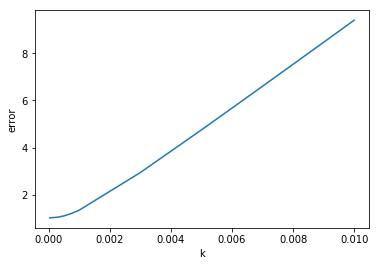

In [118]:
import matplotlib.pyplot as plt
plt.plot(k, rms_list)
plt.ylabel('error')
plt.xlabel('k')
plt.show()

In [115]:
rms_list = [2.946, 1.354, 1.294, 1.19006, 1.1073, 1.05211, 1.0287, 1.02845, 1.02814, 1.02801, 1.01987, 1.00975]
k = [ 0.003, 0.001, 0.0009, 0.0007, 0.0005, 0.0003, 0.0001, 0.00009, 0.00007, 0.00005, 0.00003, 0.00001]

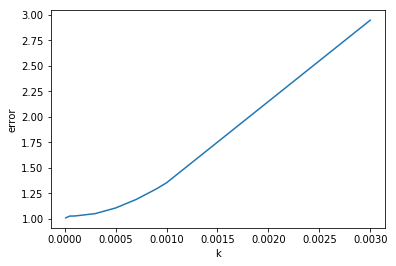

In [116]:
import matplotlib.pyplot as plt
plt.plot(k, rms_list)
plt.ylabel('error')
plt.xlabel('k')
plt.show()

## Recalculating the Ratings, with k = 0.001 for the first 1000 users.
---------------------------

In [133]:
# Root Mean Squared Error
# Root Mean Squared Error

#MAIN ---- SCRIPT -- RUN

# load the data, then print out the number of ratings, 
# movies and users in each of train and test sets.
# Your Code Here...
#test_movies_list = list of test movies
#test_user_list = list of test user, just predict their scores and store in a list!

'''
full_predicitions : will store the predicition values
'full_test_user_list': just reads from the test set and has the user_id as read from the test set.
'full_test_movies list': same as above, has the movie:
'''

from scipy import stats
import numpy as np
import math

full_pearson = {}
full_predictions = []
full_len_test_user_list = len(full_test_user_list)
users_set = set()

full_rms = []
k_list = []
full_predictionss = []

k = 0.001

full_predictionss = []
for i in range(0, full_len_test_user_list):
    user1 = full_test_user_list[i]
    #print(user1)
    users_set.add(user1)
    if len(users_set) == 1000:
        break

    #get the current movie
    movie = full_test_movies_list[i]
   # print("movie", movie)


    #movie is there, user is there, just need to predict the rating now!
    #term holds the sigma values, after k*sigma in the formula
    term = 0

    #get all the users that have rated the current movie
    common_users = full_movies_dict[movie]
    #print("common_usres", common_users)


    for user2 in common_users:
        #need to find the pearson and the total and then add, first find pearson
        if user1 + ',' + user2 not in full_pearson and user2 + ',' + user1 not in full_pearson:
            #finding the common movies rated by both the users
            #full_user_dict = {user1 : {'all' : [movie1, movie2, movie4], 'avg': 4.5, 'movie1': rating1, 'movie2': rating2.... }}
            full_common_movies = list(full_user_dict[user1]['all'] & full_user_dict[user2]['all'])
            #common_movies has the common_movies
            #need to make to lists with the ratings for the input to the pearson!
            full_rating_user1 = []
            full_rating_user2 = []
            for movie in full_common_movies:
                full_rating_user1.append(full_user_dict[user1][movie])
                full_rating_user2.append(full_user_dict[user2][movie])
            full_ratingnp_user1 = np.array(full_rating_user1)
            full_ratingnp_user2 = np.array(full_rating_user2)
            full_pear = stats.pearsonr(full_ratingnp_user1, full_ratingnp_user2)
            if not np.isnan(full_pear[0]):
                full_pearson[user1 + ',' + user2] = full_pear[0]
        if user1 + ',' + user2 in full_pearson and movie in full_user_dict[user2]:
            w = full_pearson[user1 + ',' + user2]
            v_bar = full_user_dict[user2]['avg']
            v_i_j = full_user_dict[user2][movie]

            term += w*(v_i_j - v_bar)
    if movie in full_user_dict[user2]:       
        total = full_user_dict[user1]['avg'] + k*term
        full_predictionss.append(total)

In [123]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

rms = 0
mae = 0
full_test_movies_ratingss = full_test_movies_ratings[:1014]
rms = sqrt(mean_squared_error(full_test_movies_ratingss, full_predictionss))
print(rms)
mae = mean_absolute_error(full_test_movies_ratings, full_predictionss)
print(mae)


1.44401793857
1.1463298140649523


## 2.4 Extensions

Given your results in the previous part, can you do better? For this last part you should report on your best attempt at improving MAE and RMSE. Provide code, results, plus a brief discussion on your approach.

In [128]:
#Will try to add global factors in the Collaborative filtering -- that is glabal average, user bias and movie bias
# glabal_average : global_average
# movie_bias: movie_bias[movie] - global_average
# user_bias : full_user_dict[user]['avg'] - global_average


#MAIN ---- SCRIPT -- RUN

# load the data, then print out the number of ratings, 
# movies and users in each of train and test sets.
# Your Code Here...
#test_movies_list = list of test movies
#test_user_list = list of test user, just predict their scores and store in a list!

full_len_test_user_list = len(full_test_user_list)
users_set = set()
new_prediction = []

for i in range(0, len(full_predictionss)):
    user1 = full_test_user_list[i]
    #print(user1)
    
    
    #get the current movie
    movie = full_test_movies_list[i]
    
    new_value = global_average + (movie_bias[movie] - global_average) + (full_user_dict[user]['avg'] - global_average) + full_predictionss[i]
    new_prediction.append(float(new_value)/2)
print(new_prediction[:20])
print(full_predictionss[:20])
print(full_test_movies_ratings[:20])
    

[3.097107311109201, 2.835607804103134, 2.925036746239079, 2.981002497032728, 2.730485877730386, 3.0788260267278647, 2.838593861991754, 3.2351877005368985, 3.1585061193269293, 2.8866794113718854, 3.0164601467377983, 1.8862391350988172, 2.9453973596494825, 1.693524495446044, 3.5117292427543063, 3.2002439406186554, 2.931013349846435, 2.7856320163408963, 3.1180360842792, 3.0503865735466382]
[3.8071656313263134, 3.2841666173141797, 3.4630245015860694, 3.5749560031733676, 3.0739227645686835, 3.7706030625636413, 3.2901387330914194, 4.0833264101817095, 3.9299632477617705, 3.386309831851683, 3.6458713025835086, 1.3854292793055463, 3.5037457284068765, 1.0, 4.636409494616525, 4.013438890345222, 3.474977708800782, 3.184215041789705, 3.849023177666312, 3.7137241562011885]
[1.0, 3.0, 3.0, 3.0, 1.0, 4.0, 4.0, 4.0, 4.0, 2.0, 3.0, 1.0, 4.0, 1.0, 5.0, 3.0, 4.0, 5.0, 4.0, 1.0]


In [132]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

rms = 0
mae = 0
full_test_movies_ratingss = full_test_movies_ratings[:1014]
rms = sqrt(mean_squared_error(full_test_movies_ratingss, new_prediction))
print("RMS")
print(rms)
mae = mean_absolute_error(full_test_movies_ratingss, new_prediction)
print("MAE")
print(mae)


RMS
1.03629763278
MAE
0.823651039254614


## Discussions for the first 1000 users
--------------------------------

As can be seen, both the MAE and the RMSE have improved, by factoring in the global effects, that is:
- calculating the global average.
- factoring in the user bias.
- factoring in the movie bias.

These global values have been factored in on addition with the Collaborative Filtering already done. The results obtained are better than the Collaborative Filtering approach alone!

Some more improvements can be:
- k needs to be optimized to the full first 5000 users, however, I did it for the first 1000 users, since it was faster.
- Techniques like Matrix Factorization and Latent Factor Models could be applied and checked, and hopefully better results can be obtained.